<a href="https://colab.research.google.com/github/sena-heim/Alexnet/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import os, sys, cv2, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

np.random.seed(722)

from keras.initializers import TruncatedNormal, Constant
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization
from keras.callbacks import Callback, EarlyStopping
from keras.utils.np_utils import to_categorical

In [ ]:
ROWS = 224
COLS = 224
CHANNELS = 3

ROOT_DIR = '/content/drive/MyDrive/Alexnet/'
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
CACHE_DIR = 'cache/'

FORCE_CONVERT = False

In [ ]:
%cd '/content/drive/MyDrive/Alexnet/'

/content/drive/MyDrive/アレックスネット


In [ ]:
def read(name, i):
    if i%100==0:
      print(name, i)
    return cv2.imread(name, cv2.IMREAD_COLOR)

def convert(img):
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def save(name, img, i):
    cv2.imwrite(CACHE_DIR + name, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    if i%100==0:
      print(i)
    return img

def ls(dirname):
    return [dirname + i for i in os.listdir(dirname)]

# 毎回変換していると時間がかかるので、一度変換したらキャッシュします
# キャッシュ用のディレクトリを作ります
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
if not os.path.exists(CACHE_DIR + TRAIN_DIR):
    os.mkdir(CACHE_DIR + TRAIN_DIR)
if not os.path.exists(CACHE_DIR + TEST_DIR):
    os.mkdir(CACHE_DIR + TEST_DIR)

sys.stdout.write('Loading... ')

train_files = ls(CACHE_DIR + TRAIN_DIR)
train = np.array([read(i, index) for index, i in enumerate(train_files)])

test_files = ls(CACHE_DIR + TEST_DIR)
test = np.array([read(i, index) for index, i in enumerate(test_files)])

print('Done!')


Loading... cache/train/dog.10297.jpg 0
cache/train/dog.10372.jpg 100
cache/train/dog.10457.jpg 200
cache/train/dog.10034.jpg 300
cache/train/dog.10072.jpg 400
cache/train/dog.1072.jpg 500
cache/train/dog.10806.jpg 600
cache/train/dog.10915.jpg 700
cache/train/dog.10165.jpg 800
cache/train/dog.10244.jpg 900
cache/train/dog.1116.jpg 1000
cache/train/dog.11262.jpg 1100
cache/train/dog.11358.jpg 1200
cache/train/dog.1062.jpg 1300
cache/train/dog.11534.jpg 1400
cache/train/dog.11614.jpg 1500
cache/train/dog.1174.jpg 1600
cache/train/dog.1096.jpg 1700
cache/train/dog.11051.jpg 1800
cache/train/dog.11987.jpg 1900
cache/train/dog.12107.jpg 2000
cache/train/dog.12190.jpg 2100
cache/train/dog.11454.jpg 2200
cache/train/dog.12352.jpg 2300
cache/train/dog.12427.jpg 2400
cache/train/dog.129.jpg 2500
cache/train/dog.11799.jpg 2600
cache/train/dog.11898.jpg 2700
cache/train/dog.1528.jpg 2800
cache/train/dog.1623.jpg 2900
cache/train/dog.1747.jpg 3000
cache/train/dog.12236.jpg 3100
cache/train/dog.123

In [ ]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (25000, 224, 224, 3)
Test shape: (12500, 224, 224, 3)


In [ ]:
if FORCE_CONVERT or len(train) < 25000:
    sys.stdout.write('Process train data... ')
    train =  np.array([save(TRAIN_DIR + i, convert(read(TRAIN_DIR + i, index)), index) for index, i in enumerate(os.listdir(TRAIN_DIR))])
    train_files = ls(CACHE_DIR + TRAIN_DIR)
    print('Done!')

if FORCE_CONVERT or len(test) < 12500:
    sys.stdout.write('Process test data... ')
    test =  np.array([save(TEST_DIR + i, convert(read(TEST_DIR + i, index)), index) for index, i in enumerate(os.listdir(TEST_DIR))])
    test_files = ls(CACHE_DIR + TEST_DIR)
    print('Done!')

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (25000, 224, 224, 3)
Test shape: (12500, 224, 224, 3)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


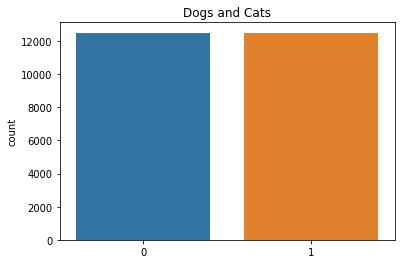

In [ ]:
labels = []
for i in train_files:
    if 'dog' in i:
        labels.append(0)
    else:
        labels.append(1)

sns.countplot(labels)
plt.title('Dogs and Cats')

labels = to_categorical(labels)
print(labels)

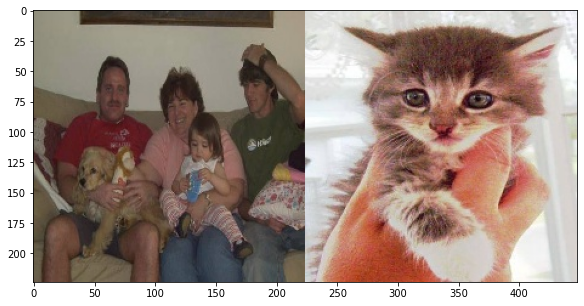

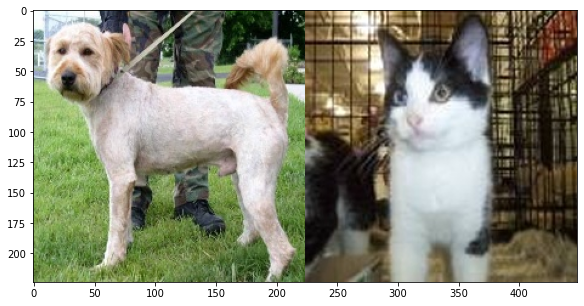

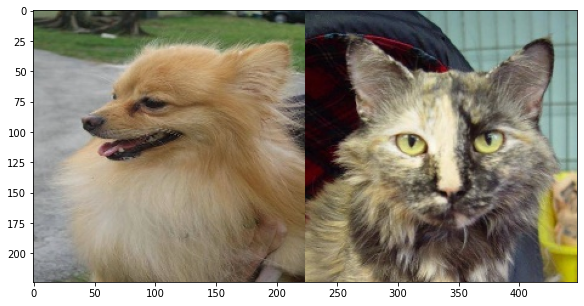

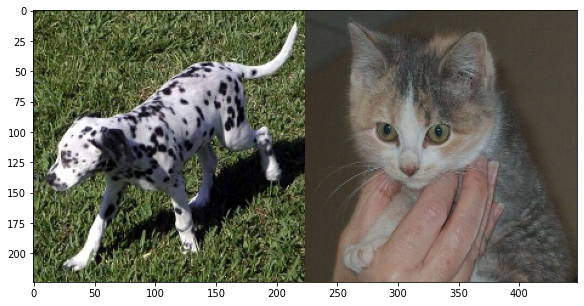

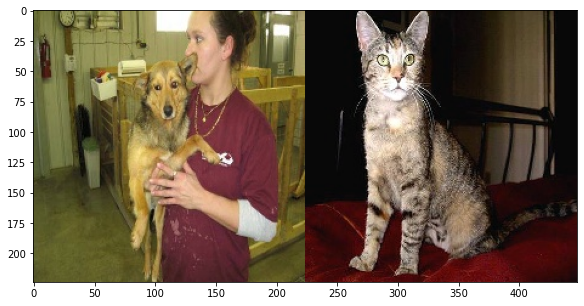

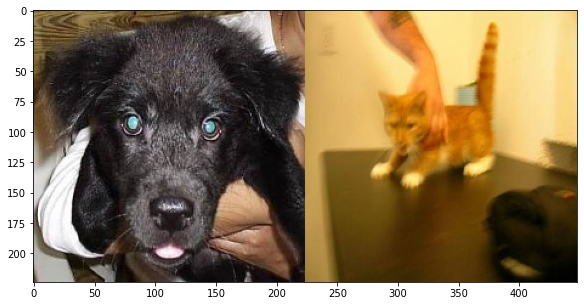

In [ ]:
train_dogs = [i for i in train_files if 'dog' in i]
train_cats = [i for i in train_files if 'cat' in i]

def show_train_image(i):
    dog = read(train_dogs[i], 1)
    cat = read(train_cats[i], 1)
    pair = np.concatenate((dog,cat), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()

for i in range(0,6):
    show_train_image(i)

In [ ]:
def conv2d(filters, kernel_size, strides=1, bias_init=1, **kwargs):
    trunc = TruncatedNormal(mean=0.0, stddev=0.01)
    cnst = Constant(value=bias_init)
    return Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding='same',
        activation='relu',
        kernel_initializer=trunc,
        bias_initializer=cnst,
        **kwargs
    )

def dense(units, **kwargs):
    trunc = TruncatedNormal(mean=0.0, stddev=0.01)
    cnst = Constant(value=1)
    return Dense(
        units,
        activation='tanh',
        kernel_initializer=trunc,
        bias_initializer=cnst,
        **kwargs
    )

def AlexNet():
    model = Sequential()

    # 第1畳み込み層
    model.add(conv2d(96, 11, strides=(4,4), bias_init=0, input_shape=(ROWS, COLS, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # 第２畳み込み層
    model.add(conv2d(256, 5, bias_init=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # 第３~5畳み込み層
    model.add(conv2d(384, 3, bias_init=0))
    model.add(conv2d(384, 3, bias_init=1))
    model.add(conv2d(256, 3, bias_init=1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # 密結合層
    model.add(Flatten())
    model.add(dense(4096))
    model.add(Dropout(0.5))
    model.add(dense(4096))
    model.add(Dropout(0.5))

    # 読み出し層
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = AlexNet()
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = model.fit(train, labels, epochs=100, batch_size=128, shuffle=True, validation_split=0.25)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 384)      

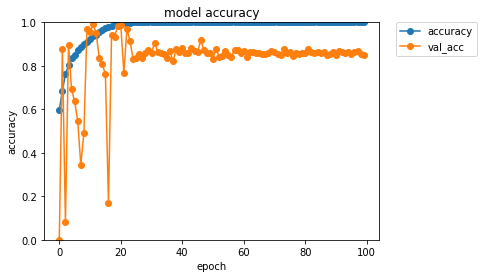

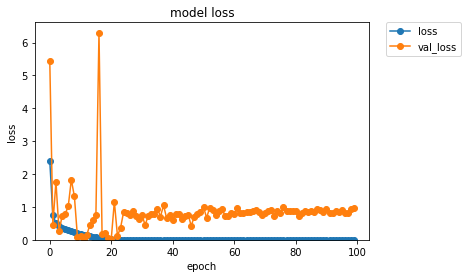

In [ ]:
def plot_history(history):
    fig = plt.figure()
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    fig.savefig("accuracy.png")

    fig = plt.figure()
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim(ymin=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    fig.savefig("loss.png")
plot_history(history)